# Install Libraries & Mount Drive

In [ ]:
# mount our google drive onto colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# check that we can access the oai project folder
!ls "/content/gdrive/My Drive/oai-xray-tkr-klg"

 728_Cohort_KLG_w_Strata.csv		  playground.ipynb
 archive				  playground_jack.ipynb
'Capstone Midterm Presentation.gslides'   playground_sanjay.ipynb
 catboost_info				  __pycache__
 CatBoost.ipynb				  README.md
 ClinicalRiskFactorsModel.ipynb		  requirements.txt
 data					  resnet34-333f7ec4.pth
 DataPrep-v4.ipynb			  TestSets
 DataPrep-v5.ipynb			  TKR-CatBoost.ipynb
 ExtractKnee				  TKR-Clinical.ipynb
'For Cem.gdoc'				  train_TL_nestedCV_strata.py
'From Cem'				  WeightedProbabilityCombo.ipynb
'From Cem.gdoc'				  XrayDataLoader.py
 inference.py				  XrayModel.ipynb
 LICENSE				  XrayModel-v2.ipynb
 ModelWeights				  XrayModel-v3.ipynb
 model_weights_default			  XrayModel-v4.ipynb
 move_data.ipynb			  XrayModel-v5.ipynb
 peter_code.zip


In [ ]:
# set that folder to be our working directory 
import os 
os.chdir("/content/gdrive/My Drive/oai-xray-tkr-klg") 
!pwd

/content/gdrive/My Drive/oai-xray-tkr-klg


In [ ]:
# !pip install -r requirements.txt (no need for now, just use latest library versions already in Colab)
!pip install pydicom 

     |████████████████████████████████| 2.0 MB 4.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import h5py
import pydicom
import datetime
from sklearn.model_selection import train_test_split, GroupShuffleSplit

# Append Info & Train/Test Split to "Final Sheet"

In [ ]:
# instead of Rick's sheet we now use Cem's full cohort sheet
sheet = pd.read_csv('data/2020_Capstone/CohortInfo/KR_cohort_2021_10_28.csv')
display(sheet.info())
sheet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8957 entries, 0 to 8956
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        8957 non-null   int64  
 1   DATE      547 non-null    object 
 2   DAYS      547 non-null    float64
 3   Side      8957 non-null   object 
 4   KR_Label  8957 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 350.0+ KB


None

,id,DATE,DAYS,Side,KR_Label
0,9002430,2010-02-15,1702.0,RIGHT,1
1,9014797,2012-01-23,2681.0,RIGHT,1
2,9015363,2008-10-15,1396.0,RIGHT,1
3,9028418,2008-10-07,1360.0,RIGHT,1
4,9030718,2008-11-05,1269.0,RIGHT,1


In [ ]:
# let's append information to it 
ORIGINAL_FP = 'data/KR_cohort_2021_10_28.csv' 
NEW_FP = 'data/KR_cohort_2021_10_28_with_splits_v2.csv' 

def generate_final_sheet(test_size=.25, original_fp=ORIGINAL_FP, new_fp=NEW_FP, label="KR_Label", patient_id='id'): 

    # read in Cem's full cohort file 
    full = pd.read_csv(original_fp)
    print(f"Input sheet contains {len(full)} knee rows")

    # add knee id and check no duplicate knees 
    out = full.assign(Knee_ID = lambda x: x[patient_id].astype(str) + '_' + x['Side'].astype(str))
    assert (out.groupby('Knee_ID').size() == 1).all() 

    # add HDF5 xray file names and flag knees without hdf5 files in Cem's folder 
    hdf5_fps = os.listdir('data/OAI_Radiographs/00m')
    out['Xray_HDF5_Filename'] = out[patient_id].astype(str) + '_00m_' + out['Side'] + '_KNEE.hdf5'
    out['Xray_HDF5_Exists'] = np.where(out['Xray_HDF5_Filename'].isin(hdf5_fps), 1, 0)
    knees_no_hdf5 = list(out.query("Xray_HDF5_Exists==0")['Knee_ID'].unique())
    print(f"{len(knees_no_hdf5)} knees have no X-ray HDF5 in Cem's Google Drive: {knees_no_hdf5}")        

    # flag samples without X-ray and label of interest 
    out['Eligible'] = np.where(out[f"Xray_HDF5_Exists"] & out[label].notnull(), 1, 0)
    print(f"Of the {len(out)} knees in CSV, only {out['Eligible'].sum()} have HDF5 X-ray image and {label} label and are eligible for our study")

    # create stratified group train/test split 
    out = out.set_index('Knee_ID')
    train_idx, test_idx, iter_df = append_stratified_group_split(df=out, label=label, test_size=test_size, group_col=patient_id, eligible_col='Eligible')
    out = out.assign(Split = lambda x: np.where(x.index.isin(train_idx), 'train', np.where(x.index.isin(test_idx), 'test', None)))
    print("Performing stratified group train/test split yields:")
    display(out.groupby(['Split'])[label].agg(['count', np.mean]))    

    # further split train set into 4 folds 
    out = append_train_fold_splits(df=out, label=label, patient_id=patient_id)

    # output to CSV 
    out = out.reset_index()
    out.to_csv(new_fp, index=False)

    return out, iter_df


def append_stratified_group_split(df, label, test_size, group_col, eligible_col=None, n_splits=1000, random_state=42):
    """ We want to split data into train/test such that: 
        (1) knees of the same patient are kept in the same split,  
        (2) splits have roughly equal proportion of positive labels 

        Currently, SKLearn only provides functions to do the former and latter separately 
        (GroupShuffleSplit and train_test_split) but not both. Here we attempt a poor-man 
        version of that by running GroupShuffleSplit `n_iter` times, and then keeping 
        the group split that is the most balanced as our final train/test split. 
    """

    # filter out non-eligible knees as defined in previous step 
    if eligible_col is not None: 
        df = df[df[eligible_col]==1]

    # initialize splitter 
    gss = GroupShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)
    groups = df[group_col]

    # for each split, compute the absolute difference in proportion of positive labels 
    results = [] 
    for i, (train_idx, test_idx) in enumerate(gss.split(X=df, groups=groups)):
        result = {} 
        result['train_idx'] = train_idx
        result['test_idx'] = test_idx
        result['train_pos'] = df.iloc[train_idx][label].mean() #df[df.index.isin(train_idx)][label].mean()
        result['test_pos'] = df.iloc[test_idx][label].mean() #df[df.index.isin(test_idx)][label].mean() 
        result['abs_diff_pos'] = np.abs(result['train_pos'] - result['test_pos'])
        results.append(result)

    # pick the split that gives the smallest difference in % of positive labels 
    out = pd.DataFrame(results)
    out = out.sort_values(by='abs_diff_pos', ascending=True)
    best = out.iloc[0]

    # return indices as knee ids 
    train_idx = df.iloc[best['train_idx']].index
    test_idx = df.iloc[best['test_idx']].index

    return train_idx, test_idx, out 

  
def append_train_fold_splits(df, label="KR_Label", patient_id='id'): 
    """ A hack to perform 4-fold group stratified splits within train data to facilitate cross validation """

    # first let's call the split func once to split data into halves 
    out = df.assign(InTrain = lambda x: np.where(x['Split'] == 'train', 1, 0))
    h1_idx, h2_idx, _ = append_stratified_group_split(df=out, test_size=.5, label=label, group_col=patient_id, eligible_col='InTrain')
    out = out.assign(Half = lambda x: np.where(x.index.isin(h1_idx), 'H1', np.where(x.index.isin(h2_idx), 'H2', None)))

    # split the first half into 2 quarters 
    out = out.assign(InH1 = lambda x: np.where(x['Half'] == 'H1', 1, 0))
    q1_idx, q2_idx, _ = append_stratified_group_split(df=out, test_size=.5, label=label, group_col=patient_id, eligible_col='InH1')
    out = out.assign(TrainFold = lambda x: np.where(x.index.isin(q1_idx), 1, np.where(x.index.isin(q2_idx), 2, np.nan)))

    # split the second half into 2 quarters 
    out = out.assign(InH2 = lambda x: np.where(x['Half'] == 'H2', 1, 0))
    q3_idx, q4_idx, _ = append_stratified_group_split(df=out, test_size=.5, label=label, group_col=patient_id, eligible_col='InH2')
    out = out.assign(TrainFold = lambda x: np.where(x.index.isin(q3_idx), 3, np.where(x.index.isin(q4_idx), 4, x['TrainFold'])))

    # drop working cols 
    out = out.drop(['InTrain', 'Half', 'InH1', 'InH2'], axis=1)

    return out 


final_sheet, iter_df = generate_final_sheet()
final_sheet.head()

Input sheet contains 8957 knee rows
25 knees have no X-ray HDF5 in Cem's Google Drive: ['9672573_RIGHT', '9746416_RIGHT', '9034963_RIGHT', '9076900_RIGHT', '9361744_RIGHT', '9362660_RIGHT', '9396968_RIGHT', '9421389_RIGHT', '9610630_RIGHT', '9728094_RIGHT', '9881625_RIGHT', '9095103_LEFT', '9466244_LEFT', '9002116_LEFT', '9076900_LEFT', '9169499_LEFT', '9170503_LEFT', '9175275_LEFT', '9330186_LEFT', '9391061_LEFT', '9413279_LEFT', '9471287_LEFT', '9590267_LEFT', '9608765_LEFT', '9728094_LEFT']
Of the 8957 knees in CSV, only 8932 have HDF5 X-ray image and KR_Label label and are eligible for our study
Performing stratified group train/test split yields:


,count,mean
Split,,
test,2237,0.060796
train,6695,0.060792


,Knee_ID,id,DATE,DAYS,Side,KR_Label,Xray_HDF5_Filename,Xray_HDF5_Exists,Eligible,Split,TrainFold
0,9002430_RIGHT,9002430,2010-02-15,1702.0,RIGHT,1,9002430_00m_RIGHT_KNEE.hdf5,1,1,train,2.0
1,9014797_RIGHT,9014797,2012-01-23,2681.0,RIGHT,1,9014797_00m_RIGHT_KNEE.hdf5,1,1,train,3.0
2,9015363_RIGHT,9015363,2008-10-15,1396.0,RIGHT,1,9015363_00m_RIGHT_KNEE.hdf5,1,1,train,1.0
3,9028418_RIGHT,9028418,2008-10-07,1360.0,RIGHT,1,9028418_00m_RIGHT_KNEE.hdf5,1,1,train,1.0
4,9030718_RIGHT,9030718,2008-11-05,1269.0,RIGHT,1,9030718_00m_RIGHT_KNEE.hdf5,1,1,train,2.0


# Inspect Image Data

(1024, 1024)


array([[283.90267542, 320.02112463, 225.91126477, ..., 636.40223604,
        569.82394667, 512.09081822],
       [285.74847222, 256.70590986, 288.62713006, ..., 696.72134098,
        589.02713401, 560.3630228 ],
       [315.22644583, 270.93168075, 288.45734147, ..., 703.7936221 ,
        590.77764701, 518.5253586 ],
       ...,
       [155.8384604 , 220.79800053, 200.04005171, ..., 191.34216374,
        158.17041036, 143.87436246],
       [143.35092957, 226.2094744 , 204.51777246, ..., 119.42246614,
        128.32155509, 129.98865248],
       [177.03164392, 181.90002506, 196.35458512, ..., 138.61427494,
        154.97985581, 149.51692998]])

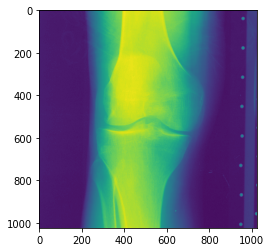

In [ ]:
# check out an example of HDF5 image 
h5_example = h5py.File('data/OAI_Radiographs/00m/9000099_00m_RIGHT_KNEE.hdf5','r')
print(h5_example['data'].shape)
display(np.array(h5_example['data']))
plt.imshow(h5_example['data']);

(1213, 1140)


array([[423, 506, 438, ..., 754, 715, 646],
       [478, 430, 441, ..., 762, 717, 627],
       [574, 525, 518, ..., 750, 735, 695],
       ...,
       [611, 645, 711, ..., 115,  95, 171],
       [645, 642, 681, ..., 104,  74, 207],
       [640, 572, 702, ...,  73,  79, 187]], dtype=uint16)

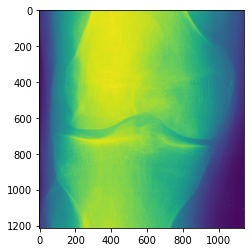

In [ ]:
# check out the same file in DICOM format 
dcm_example = pydicom.dcmread('data/cropped_dicom/9000099_1.dcm')
print(dcm_example.pixel_array.shape)
display(dcm_example.pixel_array)
plt.imshow(dcm_example.pixel_array)

(3560, 4320)


array([[4085, 4089, 4087, ..., 4091, 4094, 4094],
       [4090, 4089, 4087, ..., 4093, 4093, 4092],
       [4086, 4085, 4086, ..., 4094, 4092, 4093],
       ...,
       [4077, 4078, 4077, ..., 4094, 4094, 4093],
       [4078, 4073, 4077, ..., 4094, 4092, 4094],
       [4078, 4077, 4078, ..., 4092, 4089, 4093]], dtype=uint16)

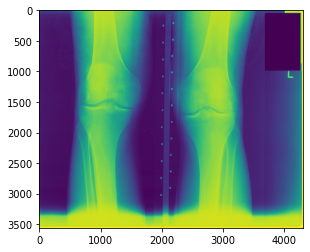

In [ ]:
# check the original uncropped image 
dcm_example_original = pydicom.dcmread('data/original_baseline_dicom/9000099.dcm')
print(dcm_example_original.pixel_array.shape)
display(dcm_example_original.pixel_array)
plt.imshow(dcm_example_original.pixel_array)